Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'SMA_50',
       'MACD', 'MACD_Signal', 'ATR', 'RSI', 'BB_Middle', 'BB_Std', 'BB_Upper',
       'BB_Lower', 'TR', 'DMplus', 'DMminus', 'TR14', 'DMplus14', 'DMminus14',
       'DIplus14', 'DIminus14', 'DX', 'ADX'],
      dtype='object')


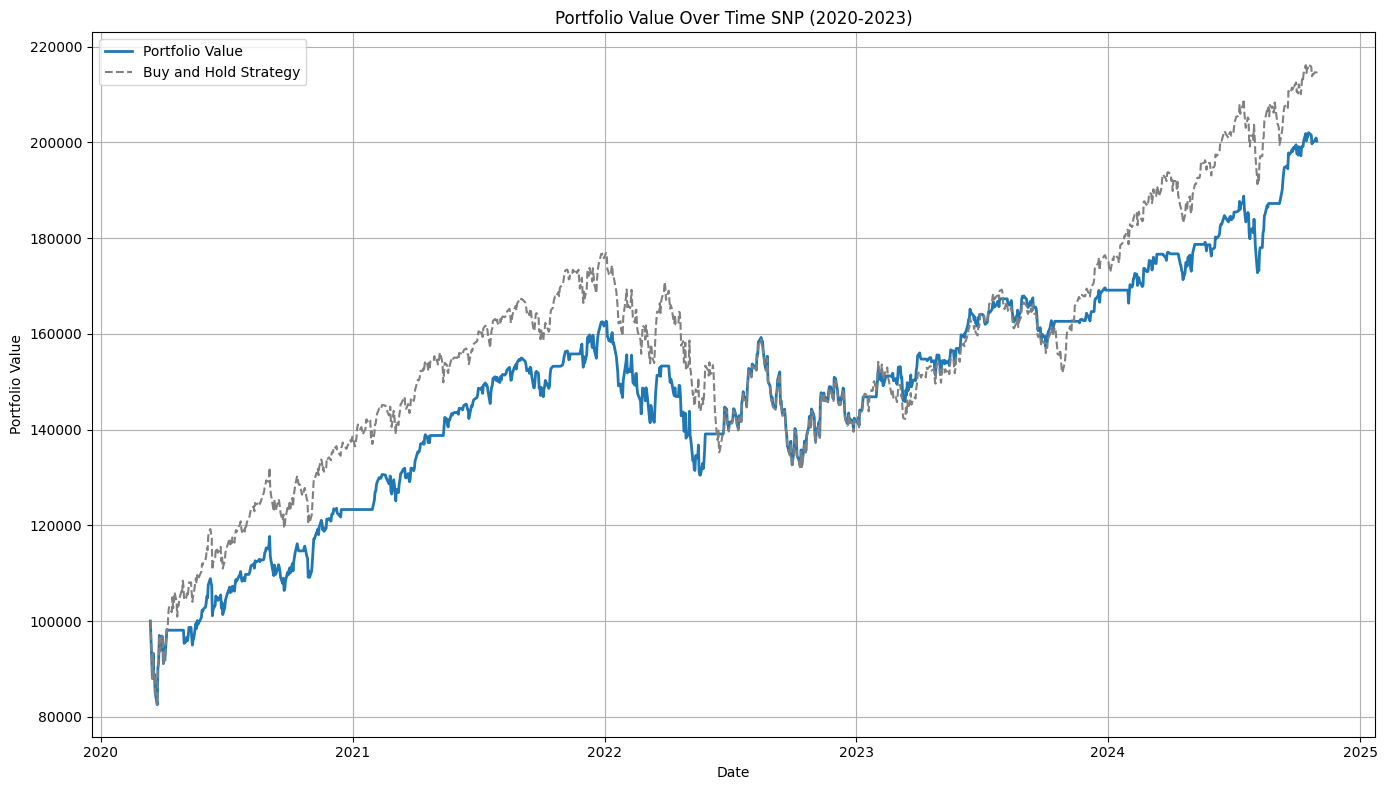

{'Final Portfolio Value': 200281.56373246477, 'Cumulative Return (%)': 100.28156373246478, 'Sharpe Ratio': np.float64(0.905152144721125), 'Maximum Drawdown (%)': np.float64(-19.784045331865908)}


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = ".data/snp500_daily.csv"  # Adjust to your file path
snp500_data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime
snp500_data["Date"] = pd.to_datetime(snp500_data["Date"])

# Sort the data by date
snp500_data.sort_values(by="Date", inplace=True)

# snp500_data.set_index('Date', inplace=True)

# Calculate key technical indicators
snp500_data["SMA_20"] = snp500_data["Close"].rolling(window=20).mean()
snp500_data["SMA_50"] = snp500_data["Close"].rolling(window=50).mean()
snp500_data["MACD"] = (
    snp500_data["Close"].ewm(span=12, adjust=False).mean()
    - snp500_data["Close"].ewm(span=26, adjust=False).mean()
)
snp500_data["MACD_Signal"] = snp500_data["MACD"].ewm(span=9, adjust=False).mean()

snp500_data["ATR"] = (
    (snp500_data["High"] - snp500_data["Low"]).rolling(window=14).mean()
)


# RSI calculation
delta = snp500_data["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
snp500_data["RSI"] = 100 - (100 / (1 + rs))

# Bollinger Bands
snp500_data["BB_Middle"] = snp500_data["Close"].rolling(window=20).mean()
snp500_data["BB_Std"] = snp500_data["Close"].rolling(window=20).std()
snp500_data["BB_Upper"] = snp500_data["BB_Middle"] + (2 * snp500_data["BB_Std"])
snp500_data["BB_Lower"] = snp500_data["BB_Middle"] - (2 * snp500_data["BB_Std"])

# ADX calculation
snp500_data["TR"] = np.maximum(
    snp500_data["High"] - snp500_data["Low"],
    np.maximum(
        abs(snp500_data["High"] - snp500_data["Close"].shift(1)),
        abs(snp500_data["Low"] - snp500_data["Close"].shift(1)),
    ),
)

snp500_data["DMplus"] = np.where(
    (snp500_data["High"] - snp500_data["High"].shift(1))
    > (snp500_data["Low"].shift(1) - snp500_data["Low"]),
    np.maximum(snp500_data["High"] - snp500_data["High"].shift(1), 0),
    0,
)

snp500_data["DMminus"] = np.where(
    (snp500_data["Low"].shift(1) - snp500_data["Low"])
    > (snp500_data["High"] - snp500_data["High"].shift(1)),
    np.maximum(snp500_data["Low"].shift(1) - snp500_data["Low"], 0),
    0,
)

snp500_data["TR14"] = snp500_data["TR"].rolling(window=14).sum()

snp500_data["DMplus14"] = snp500_data["DMplus"].rolling(window=14).sum()

snp500_data["DMminus14"] = snp500_data["DMminus"].rolling(window=14).sum()

snp500_data["DIplus14"] = 100 * (snp500_data["DMplus14"] / snp500_data["TR14"])
snp500_data["DIminus14"] = 100 * (snp500_data["DMminus14"] / snp500_data["TR14"])
snp500_data["DX"] = 100 * (
    np.abs(snp500_data["DIplus14"] - snp500_data["DIminus14"])
    / (snp500_data["DIplus14"] + snp500_data["DIminus14"])
)
snp500_data["ADX"] = snp500_data["DX"].rolling(window=14).mean()

snp500_data.dropna(inplace=True)

print(snp500_data.columns)


# Adjusted refined signal generation function
def adjust_signals(
    data,
    rsi_oversold=40,
    rsi_overbought=60,
    bb_band=0.5,
    adx_threshold=25,
    buy_threshold=3,
    sell_threshold=4,
):
    # Individual conditions for Buy
    buy_conditions = [
        (data["RSI"] < rsi_oversold),  # Moderately oversold
        (data["SMA_20"] > data["SMA_50"]),  # Bullish crossover
        (data["MACD"] > data["MACD_Signal"]),  # MACD crossover
        (
            data["Close"]
            <= (data["BB_Lower"] + ((data["BB_Middle"] - data["BB_Lower"]) * bb_band))
        ),  # Near Bollinger Lower Band
        (data["ADX"] > adx_threshold),  # Trending market
    ]

    # Individual conditions for Sell
    sell_conditions = [
        (data["RSI"] > rsi_overbought),  # Moderately overbought
        (data["SMA_20"] < data["SMA_50"]),  # Bearish crossover
        (data["MACD"] < data["MACD_Signal"]),  # MACD crossover
        (
            data["Close"]
            >= (data["BB_Upper"] - ((data["BB_Upper"] - data["BB_Middle"]) * bb_band))
        ),  # Near Bollinger Upper Band
        (data["ADX"] > adx_threshold),  # Trending market
    ]

    # Buy/Sell signals if at least 2 conditions are true
    data["Buy_Signal"] = sum(buy_conditions)
    data["Sell_Signal"] = sum(sell_conditions)

    # print(data['Buy_Signal'].value_counts())
    # print(data['Sell_Signal'].value_counts())
    # print('\n-------------------\n')

    # drop overlapping signals (Buy and Sell at the same time)
    # if sum of buy signal is more than sell signal, then drop sell signal
    # if sum of sell signal is more than buy signal, then drop buy signal

    if data["Buy_Signal"].sum() > data["Sell_Signal"].sum():
        data.loc[data["Sell_Signal"] == 1, "Sell_Signal"] = 0

    elif data["Buy_Signal"].sum() < data["Sell_Signal"].sum():
        data.loc[data["Buy_Signal"] == 1, "Buy_Signal"] = 0

    # print(data['Buy_Signal'].value_counts())
    # print(data['Sell_Signal'].value_counts())

    # Generate final signals
    data["Adjusted_Signal"] = 0
    data.loc[data["Buy_Signal"] >= buy_threshold, "Adjusted_Signal"] = 1  # Buy signal
    data.loc[
        data["Sell_Signal"] >= sell_threshold, "Adjusted_Signal"
    ] = -1  # Sell signal

    return data


# Apply adjusted signal generation
snp500_data = adjust_signals(snp500_data)

# Filter data for the specified range (2020 to 2023)
filtered_data = snp500_data

# Initialize backtesting parameters
initial_capital = 100000  # Starting capital
position = 0  # Current position (number of shares)
cash = initial_capital  # Cash available
portfolio_value = []  # Track portfolio value over time

# Backtesting logic
for _, row in filtered_data.iterrows():
    if row["Adjusted_Signal"] == 1:  # Buy signal
        if cash > 0:  # Only buy if we have cash
            position = cash / row["Close"]  # Buy as many shares as possible
            cash = 0  # All cash is used

    elif row["Adjusted_Signal"] == -1:  # Sell signal
        if position > 0:  # Only sell if we have a position
            cash = position * row["Close"]  # Sell all shares
            position = 0  # Reset position to zero

    # Calculate the portfolio value
    current_value = cash + (position * row["Close"])  # Cash + value of current position
    portfolio_value.append(current_value)

# Add portfolio value to the dataframe
filtered_data["Portfolio_Value"] = portfolio_value

# Calculate performance metrics
final_portfolio_value = portfolio_value[-1]
cumulative_return = (final_portfolio_value - initial_capital) / initial_capital * 100
filtered_data["Daily_Return"] = filtered_data["Portfolio_Value"].pct_change()
sharpe_ratio = (
    filtered_data["Daily_Return"].mean()
    / filtered_data["Daily_Return"].std()
    * (252**0.5)
)
max_drawdown = (
    filtered_data["Portfolio_Value"] / filtered_data["Portfolio_Value"].cummax() - 1
).min()

# Results summary
backtest_results = {
    "Final Portfolio Value": final_portfolio_value,
    "Cumulative Return (%)": cumulative_return,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (%)": max_drawdown * 100,
}

# Plot portfolio value over time vs buy and hold strategy

# Calculate buy and hold strategy
initial_price = filtered_data["Close"].iloc[0]
buy_hold_portfolio_value = filtered_data["Close"] / initial_price * initial_capital

# Plot portfolio value over time
plt.figure(figsize=(14, 8))
plt.plot(
    filtered_data["Date"],
    filtered_data["Portfolio_Value"],
    label="Portfolio Value",
    linewidth=2,
)

# Plot buy and hold strategy
plt.plot(
    filtered_data["Date"],
    buy_hold_portfolio_value,
    label="Buy and Hold Strategy",
    linestyle="--",
    color="gray",
)

# Add title and labels
plt.title("Portfolio Value Over Time SNP (2020-2023)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print backtest results
print(backtest_results)


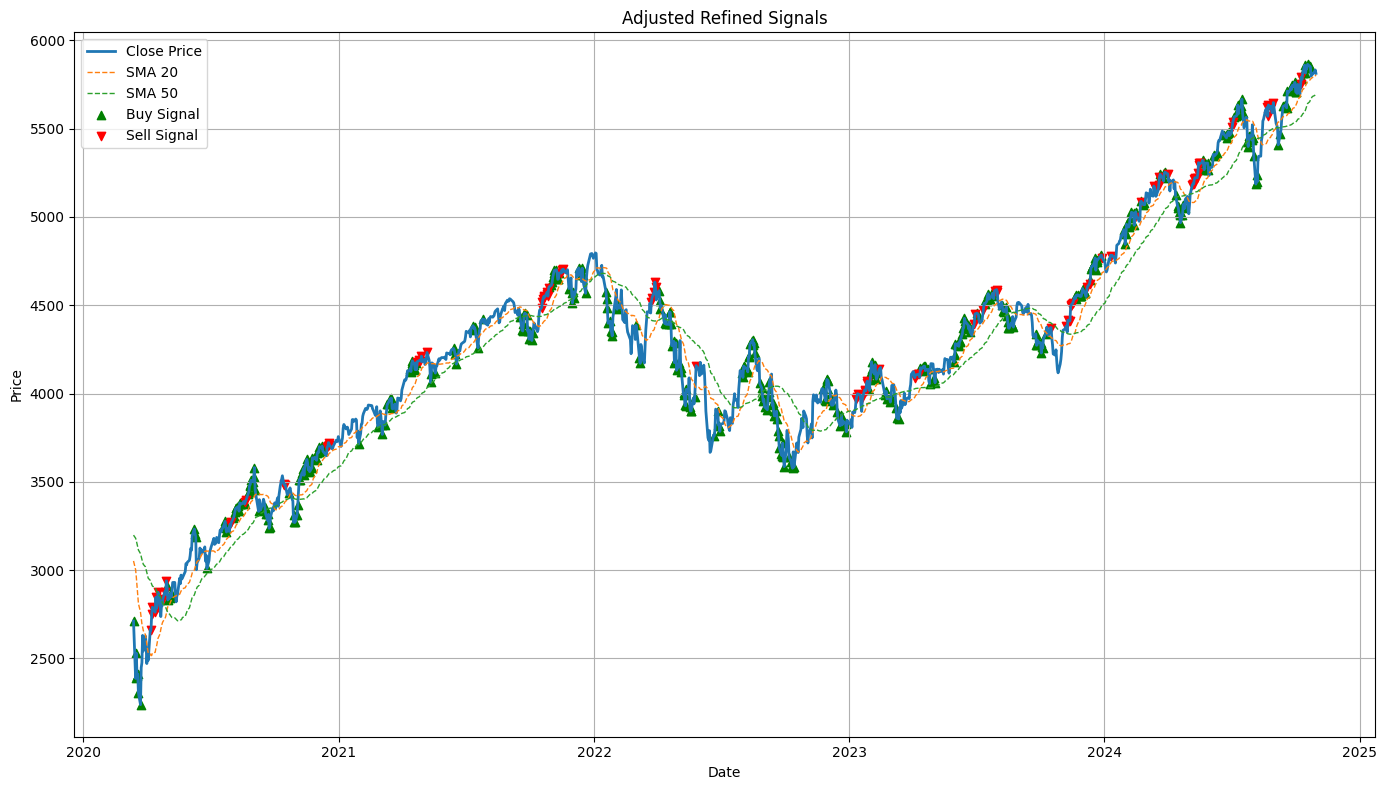

In [3]:
# plot signals
plt.figure(figsize=(14, 8))
plt.plot(
    filtered_data["Date"], filtered_data["Close"], label="Close Price", linewidth=2
)
plt.plot(
    filtered_data["Date"],
    filtered_data["SMA_20"],
    label="SMA 20",
    linestyle="--",
    linewidth=1,
)
plt.plot(
    filtered_data["Date"],
    filtered_data["SMA_50"],
    label="SMA 50",
    linestyle="--",
    linewidth=1,
)
plt.scatter(
    filtered_data[filtered_data["Adjusted_Signal"] == 1]["Date"],
    filtered_data[filtered_data["Adjusted_Signal"] == 1]["Close"],
    marker="^",
    color="g",
    label="Buy Signal",
)
plt.scatter(
    filtered_data[filtered_data["Adjusted_Signal"] == -1]["Date"],
    filtered_data[filtered_data["Adjusted_Signal"] == -1]["Close"],
    marker="v",
    color="r",
    label="Sell Signal",
)
plt.title("Adjusted Refined Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [4]:
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
import numpy as np


# Walk-forward optimization function
def optimize_signal_thresholds(data, param_grid, initial_capital=100000):
    """
    Optimize thresholds for `adjust_signals` to maximize returns and Sharpe ratio.

    Parameters:
        data (pd.DataFrame): DataFrame with required columns for `adjust_signals`.
        param_grid (dict): Dictionary of parameter ranges for optimization.
        initial_capital (int): Starting capital for backtesting.

    Returns:
        dict: Best parameters for thresholds.
        float: Best Sharpe ratio achieved during optimization.
    """
    # Initialize walk-forward cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    best_params = None
    best_performance = -np.inf

    # Iterate over parameter combinations
    for params in ParameterGrid(param_grid):
        total_return = []
        sharpe_ratios = []

        for train_index, test_index in tscv.split(data):
            # Train/Test split
            train_data = data.iloc[train_index].copy()
            test_data = data.iloc[test_index].copy()

            # Apply the `adjust_signals` function with current parameters
            train_data = adjust_signals(
                train_data,
                rsi_oversold=params["rsi_oversold"],
                rsi_overbought=params["rsi_overbought"],
                bb_band=params["bb_band"],
                adx_threshold=params["adx_threshold"],
                buy_threshold=params["buy_threshold"],
                sell_threshold=params["sell_threshold"],
            )
            test_data = adjust_signals(
                test_data,
                rsi_oversold=params["rsi_oversold"],
                rsi_overbought=params["rsi_overbought"],
                bb_band=params["bb_band"],
                adx_threshold=params["adx_threshold"],
                buy_threshold=params["buy_threshold"],
                sell_threshold=params["sell_threshold"],
            )

            # Backtesting
            position = 0
            cash = initial_capital
            portfolio_value = []
            for _, row in test_data.iterrows():
                current_price = row["Close"]
                if row["Adjusted_Signal"] == 1:  # Buy signal
                    if cash > 0:
                        position = cash / current_price
                        cash = 0
                elif row["Adjusted_Signal"] == -1:  # Sell signal
                    if position > 0:
                        cash = position * current_price
                        position = 0
                portfolio_value.append(cash + position * current_price)

            # Calculate performance metrics
            cumulative_return = (
                portfolio_value[-1] - initial_capital
            ) / initial_capital
            daily_returns = np.diff(portfolio_value) / portfolio_value[:-1]
            sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)

            total_return.append(cumulative_return)
            sharpe_ratios.append(sharpe_ratio)

        # Average performance across splits
        avg_return = np.mean(total_return)
        avg_sharpe = np.mean(sharpe_ratios)

        # Update best parameters
        if avg_sharpe > best_performance:
            best_performance = avg_sharpe
            best_params = params

    return best_params, best_performance


In [32]:
# Parameter grid
param_grid = {
    "rsi_oversold": [20, 25, 30, 35, 40, 45],
    "rsi_overbought": [60, 65, 70, 75],
    "bb_band": [0.2, 0.3, 0.5, 0.7],
    "adx_threshold": [20, 25, 30],
    "buy_threshold": [2, 3, 4],
    "sell_threshold": [2, 3, 4],
}

# Run optimization
best_params, best_sharpe = optimize_signal_thresholds(snp500_data, param_grid)

print("Best Parameters:", best_params)
print("Best Sharpe Ratio:", best_sharpe)


/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3307932584.py:76: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3307932584.py:76: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3307932584.py:76: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3307932584.py:76: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3307932584.py:76: RuntimeWarning: invalid value enc

Best Parameters: {'adx_threshold': 25, 'bb_band': 0.5, 'buy_threshold': 3, 'rsi_overbought': 60, 'rsi_oversold': 45, 'sell_threshold': 4}
Best Sharpe Ratio: 1.3029603370435168


/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3307932584.py:76: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3307932584.py:76: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3307932584.py:76: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3307932584.py:76: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3307932584.py:76: RuntimeWarning: invalid value enc

In [33]:
# Apply the best parameters to the data

valid_data = snp500_data.copy()

valid_data = valid_data.loc[valid_data["Date"] >= "2021-01-01"]

snp500_data_optimized = adjust_signals(
    valid_data,
    rsi_oversold=best_params["rsi_oversold"],
    rsi_overbought=best_params["rsi_overbought"],
    bb_band=best_params["bb_band"],
    adx_threshold=best_params["adx_threshold"],
    buy_threshold=best_params["buy_threshold"],
    sell_threshold=best_params["sell_threshold"],
)

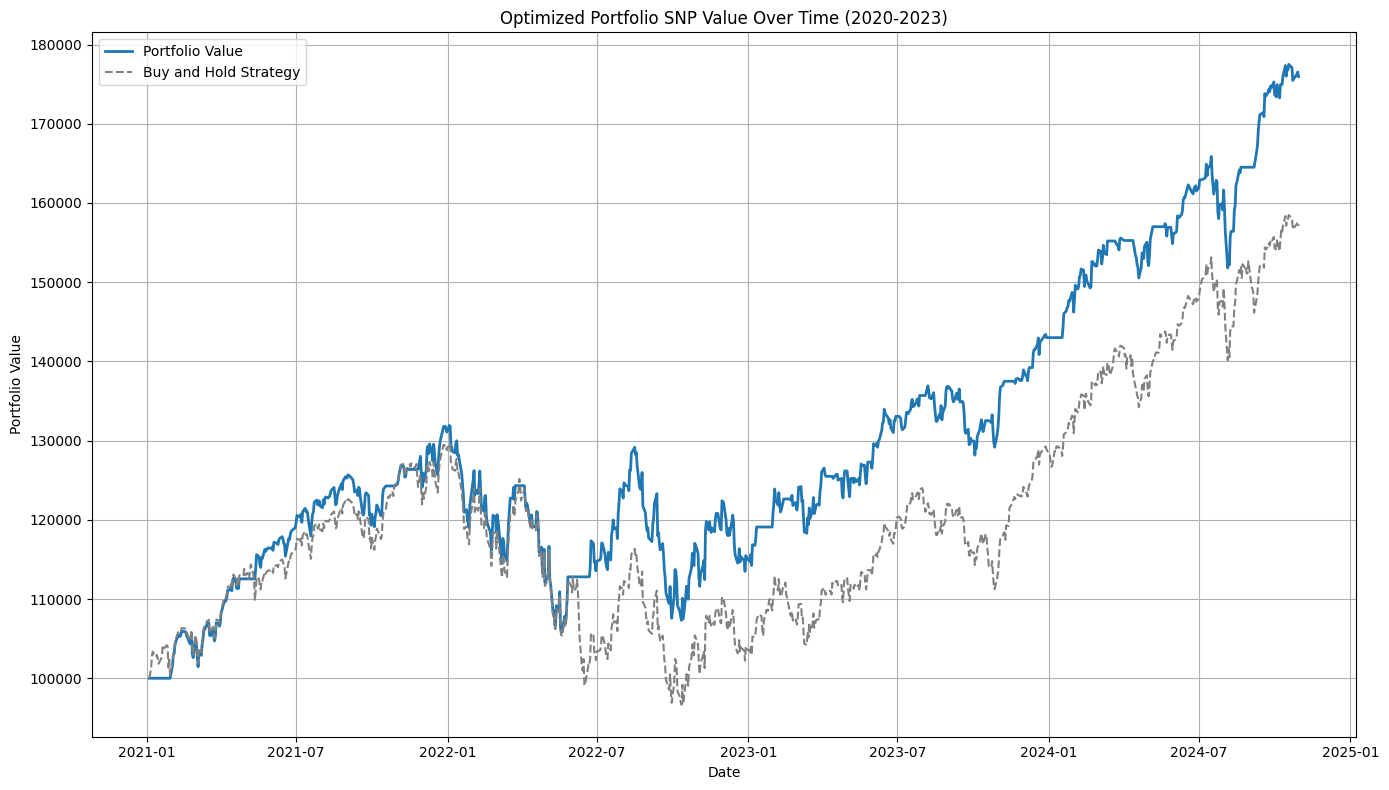

{'Final Portfolio Value': 175958.70521105037, 'Cumulative Return (%)': 75.95870521105037, 'Sharpe Ratio': np.float64(1.0474215530879543), 'Num of Trades': np.int64(963), 'Maximum Drawdown (%)': np.float64(-19.784045331865897)}


In [ ]:
## Back testing
# Initialize backtesting parameters

initial_capital = 100000  # Starting capital
position = 0  # Current position (number of shares)
cash = initial_capital  # Cash available
portfolio_value = []  # Track portfolio

# Backtesting logic

for _, row in snp500_data_optimized.iterrows():
    if row["Adjusted_Signal"] == 1:  # Buy signal
        if cash > 0:  # Only buy if we have cash
            position = cash / row["Close"]  # Buy as many shares as possible
            cash = 0  # All cash is used

    elif row["Adjusted_Signal"] == -1:  # Sell signal
        if position > 0:  # Only sell if we have a position
            cash = position * row["Close"]  # Sell all shares
            position = 0  # Reset position to zero

    # Calculate the portfolio value
    current_value = cash + (position * row["Close"])  # Cash + value of current position
    portfolio_value.append(current_value)

# Add portfolio value to the dataframe
snp500_data_optimized["Portfolio_Value"] = portfolio_value

# Calculate performance metrics
final_portfolio_value = portfolio_value[-1]
cumulative_return = (final_portfolio_value - initial_capital) / initial_capital * 100
snp500_data_optimized["Daily_Return"] = snp500_data_optimized[
    "Portfolio_Value"
].pct_change()
sharpe_ratio = (
    snp500_data_optimized["Daily_Return"].mean()
    / snp500_data_optimized["Daily_Return"].std()
    * (252**0.5)
)
max_drawdown = (
    snp500_data_optimized["Portfolio_Value"]
    / snp500_data_optimized["Portfolio_Value"].cummax()
    - 1
).min()

no_of_trades = snp500_data_optimized["Adjusted_Signal"].value_counts().sum()

# Results summary
backtest_results = {
    "Final Portfolio Value": final_portfolio_value,
    "Cumulative Return (%)": cumulative_return,
    "Sharpe Ratio": sharpe_ratio,
    "Num of Trades": no_of_trades,
    "Maximum Drawdown (%)": max_drawdown * 100,
}

# Plot portfolio value over time vs buy and hold strategy

# Calculate buy and hold strategy
initial_price = snp500_data_optimized["Close"].iloc[0]
buy_hold_portfolio_value = (
    snp500_data_optimized["Close"] / initial_price * initial_capital
)

# Plot portfolio value over time
plt.figure(figsize=(14, 8))
plt.plot(
    snp500_data_optimized["Date"],
    snp500_data_optimized["Portfolio_Value"],
    label="Portfolio Value",
    linewidth=2,
)

# Plot buy and hold strategy
plt.plot(
    snp500_data_optimized["Date"],
    buy_hold_portfolio_value,
    label="Buy and Hold Strategy",
    linestyle="--",
    color="gray",
)

# Add title and labels

plt.title("Optimized Portfolio SNP Value Over Time (2020-2023)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Print backtest results
print(backtest_results)


In [41]:
# Redefine the target variable based on changes in close prices
def prepare_ml_data_with_price_change(
    data, threshold=0.002
):  # 0.2% threshold for Buy/Sell
    # Calculate the percentage change in close prices
    data["Close_Change"] = data["Close"].pct_change().shift(-1)

    # Define target variable
    data["Target"] = 0  # Default Hold
    data.loc[data["Close_Change"] > threshold, "Target"] = 1  # Buy
    data.loc[data["Close_Change"] < -threshold, "Target"] = -1  # Sell

    data.drop(columns=["Close_Change"], inplace=True)

    # Feature Engineering: Avoid using future information
    data["Momentum"] = data["Close"].pct_change(5)  # 5-day momentum
    data["ATR_Lag_1"] = data["ATR"].shift(1)
    data["RSI_Lag_1"] = data["RSI"].shift(1)
    data["SMA_20_Lag_1"] = data["SMA_20"].shift(1)
    data["SMA_50_Lag_1"] = data["SMA_50"].shift(1)
    data["Daily_Return_Lag_1"] = data["Daily_Return"].shift(1)
    data["BB_Width_Lag_1"] = (data["BB_Upper"] - data["BB_Lower"]).shift(1)

    # Drop rows with NaNs (caused by lags and shifts)
    return data.dropna()


# Apply the new data preparation method
snp500_ml_data = prepare_ml_data_with_price_change(snp500_data_optimized)

# Define features (X) and target (y)
features = [
    "RSI_Lag_1",
    "SMA_20_Lag_1",
    "SMA_50_Lag_1",
    "Daily_Return_Lag_1",
    "BB_Width_Lag_1",
    "Momentum",
    "ADX",
    "ATR_Lag_1",
]
X = snp500_ml_data[features]
y = snp500_ml_data["Target"]

# Check the updated dataset structure
snp500_ml_data[["Date", "Target"] + features].head()


,Date,Target,RSI_Lag_1,SMA_20_Lag_1,SMA_50_Lag_1,Daily_Return_Lag_1,BB_Width_Lag_1,Momentum,ADX,ATR_Lag_1
258,2021-01-11,0,67.026494,3716.830505,3618.637798,0.0,173.811657,0.026741,9.997500,41.538557
259,2021-01-12,1,64.449597,3723.406006,3629.209399,0.0,182.354254,0.019944,12.048670,40.680001
260,2021-01-13,-1,67.758436,3730.292505,3639.030996,0.0,185.804334,0.016462,14.306573,38.383580
261,2021-01-14,-1,70.416389,3738.410010,3649.828599,0.0,181.572184,-0.002169,16.427502,38.909284
262,2021-01-15,1,66.925412,3743.456006,3659.534600,0.0,183.502963,-0.014754,16.460235,39.536429


In [45]:
# Walk-forward validation with ensemble model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)

# Initialize walk-forward cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Ensemble model: Combine Random Forest and Gradient Boosting
ensemble_model = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(random_state=42, class_weight="balanced")),
        ("gb", GradientBoostingClassifier(random_state=42)),
    ],
    voting="soft",  # Use soft voting for confidence scores
)

# Store results
results_df = pd.DataFrame(
    columns=["Date", "ML_Prediction", "Confidence", "TA_Signal", "Hybrid_Signal"]
)
feature_importance_df = pd.DataFrame(columns=["features", "importance"])

for train_index, test_index in tscv.split(X):
    # Split data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dates_test = snp500_ml_data.iloc[test_index]["Date"]
    ta_signals_test = snp500_ml_data.iloc[test_index]["Adjusted_Signal"]

    # Train the ensemble model
    ensemble_model.fit(X_train, y_train)

    # print feature importance and store the results
    feature_importance_df = pd.concat(
        [
            feature_importance_df,
            pd.DataFrame(
                {
                    "features": features,
                    "importance": ensemble_model.estimators_[0].feature_importances_,
                }
            ),
        ],
        ignore_index=True,
    )

    print(feature_importance_df.head())

    # Predict on the test set
    probabilities = ensemble_model.predict_proba(X_test)
    predictions = ensemble_model.predict(X_test)
    confidences = probabilities.max(axis=1)  # Confidence scores (max probability)

    # Generate Hybrid Signal: Use ML prediction if confidence is high, otherwise TA signal
    high_confidence_threshold = 0.75
    hybrid_signals = [
        pred if conf > high_confidence_threshold else ta
        for pred, conf, ta in zip(predictions, confidences, ta_signals_test)
    ]

    # Store results
    temp_df = pd.DataFrame(
        {
            "Date": dates_test,
            "ML_Prediction": predictions,
            "Confidence": confidences,
            "TA_Signal": ta_signals_test,
            "Hybrid_Signal": hybrid_signals,
        }
    )
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Sort by date
results_df.sort_values(by="Date", inplace=True)
results_df.reset_index(drop=True, inplace=True)

# Check the results
print(results_df.head())


/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3186053310.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat(
/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_85603/3186053310.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


             features  importance
0           RSI_Lag_1    0.124876
1        SMA_20_Lag_1    0.114397
2        SMA_50_Lag_1    0.111252
3  Daily_Return_Lag_1    0.122847
4      BB_Width_Lag_1    0.106935
             features  importance
0           RSI_Lag_1    0.124876
1        SMA_20_Lag_1    0.114397
2        SMA_50_Lag_1    0.111252
3  Daily_Return_Lag_1    0.122847
4      BB_Width_Lag_1    0.106935
             features  importance
0           RSI_Lag_1    0.124876
1        SMA_20_Lag_1    0.114397
2        SMA_50_Lag_1    0.111252
3  Daily_Return_Lag_1    0.122847
4      BB_Width_Lag_1    0.106935
             features  importance
0           RSI_Lag_1    0.124876
1        SMA_20_Lag_1    0.114397
2        SMA_50_Lag_1    0.111252
3  Daily_Return_Lag_1    0.122847
4      BB_Width_Lag_1    0.106935
             features  importance
0           RSI_Lag_1    0.124876
1        SMA_20_Lag_1    0.114397
2        SMA_50_Lag_1    0.111252
3  Daily_Return_Lag_1    0.122847
4      BB_Widt

In [46]:
results_df.sort_values(by="Confidence", ascending=False)

,Date,ML_Prediction,Confidence,TA_Signal,Hybrid_Signal
59,2021-11-26,1,0.878398,1,1
11,2021-09-20,1,0.872048,1,1
13,2021-09-22,1,0.871216,1,1
153,2022-04-12,1,0.858727,1,1
74,2021-12-17,1,0.851677,0,1
...,...,...,...,...,...
583,2023-12-28,0,0.347886,1,1
584,2023-12-29,-1,0.342172,-1,-1
601,2024-01-25,0,0.340574,0,0
307,2022-11-21,0,0.339320,0,0


In [47]:
# Backtesting Hybrid Signals
initial_capital = 100000  # Starting capital
position = 0  # Number of shares held
cash = initial_capital  # Initial cash
portfolio_value = []  # Track portfolio value
entry_price = None  # Track entry price for stop-loss/take-profit

# Stop-loss and take-profit parameters
stop_loss_pct = 0.05  # 5% stop-loss
take_profit_pct = 0.1  # 10% take-profit

# Iterate through the hybrid signals
for _, row in results_df.iterrows():
    current_price = snp500_ml_data.loc[
        snp500_ml_data["Date"] == row["Date"], "Close"
    ].values[0]

    # Apply stop-loss and take-profit rules
    if position > 0 and entry_price:
        if (current_price <= entry_price * (1 - stop_loss_pct)) or (
            current_price >= entry_price * (1 + take_profit_pct)
        ):
            cash = position * current_price  # Sell all shares
            position = 0
            entry_price = None  # Reset entry price

    # Execute Hybrid Signal
    if row["Hybrid_Signal"] == 1:  # Buy signal
        if cash > 0:
            position = cash / current_price  # Buy as many shares as possible
            entry_price = current_price  # Set entry price
            cash = 0

    elif row["Hybrid_Signal"] == -1:  # Sell signal
        if position > 0:
            cash = position * current_price  # Sell all shares
            position = 0
            entry_price = None  # Reset entry price

    # Calculate portfolio value
    current_value = cash + (position * current_price)
    portfolio_value.append(current_value)

# Add portfolio value to results_df
results_df["Portfolio_Value"] = portfolio_value

# Calculate performance metrics
final_portfolio_value = portfolio_value[-1]
cumulative_return = (final_portfolio_value - initial_capital) / initial_capital * 100
results_df["Daily_Return"] = results_df["Portfolio_Value"].pct_change()
sharpe_ratio = (
    results_df["Daily_Return"].mean() / results_df["Daily_Return"].std() * (252**0.5)
)
max_drawdown = (
    results_df["Portfolio_Value"] / results_df["Portfolio_Value"].cummax() - 1
).min()
number_of_trades = results_df["Hybrid_Signal"].diff().abs().sum()
time_in_market = results_df["Hybrid_Signal"].abs().sum() / len(results_df)

# Backtest summary
backtest_results = {
    "Final Portfolio Value": final_portfolio_value,
    "Cumulative Return (%)": cumulative_return,
    "Sharpe Ratio": sharpe_ratio,
    "Maximum Drawdown (%)": max_drawdown * 100,
    "number_of_trades": number_of_trades,
    "time_in_market": time_in_market,
}

# Print backtest results
print(backtest_results)


{'Final Portfolio Value': np.float64(142152.2609960661), 'Cumulative Return (%)': np.float64(42.15226099606609), 'Sharpe Ratio': np.float64(0.7769779151236745), 'Maximum Drawdown (%)': np.float64(-19.784045331865908), 'number_of_trades': 176, 'time_in_market': 0.5685534591194968}


In [48]:
results_df["Date"]

0     2021-09-02
1     2021-09-03
2     2021-09-07
3     2021-09-08
4     2021-09-09
         ...    
790   2024-10-24
791   2024-10-25
792   2024-10-28
793   2024-10-29
794   2024-10-30
Name: Date, Length: 795, dtype: datetime64[ns]

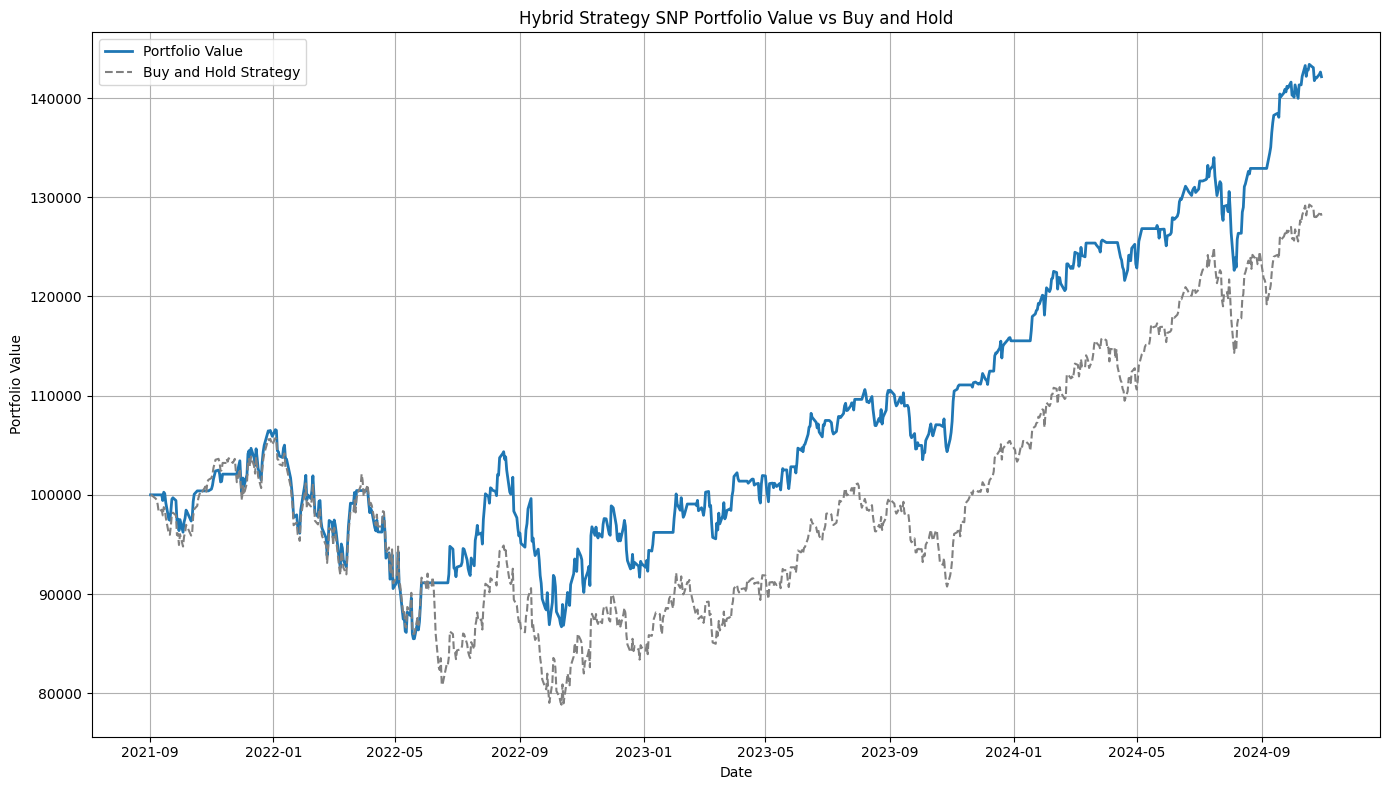

In [49]:
# plot results df vs buy and hold strategy

# Calculate buy and hold strategy
results_df["Close"] = snp500_ml_data.loc[
    snp500_ml_data["Date"].isin(results_df["Date"]), "Close"
].values
initial_price = results_df["Close"].iloc[0]
buy_hold_portfolio_value = results_df["Close"] / initial_price

# Plot portfolio value over time
plt.figure(figsize=(14, 8))
plt.plot(
    results_df["Date"],
    results_df["Portfolio_Value"],
    label="Portfolio Value",
    linewidth=2,
)
plt.plot(
    results_df["Date"],
    buy_hold_portfolio_value * initial_capital,
    label="Buy and Hold Strategy",
    linestyle="--",
    color="gray",
)
plt.title("Hybrid Strategy SNP Portfolio Value vs Buy and Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Monte Carlo

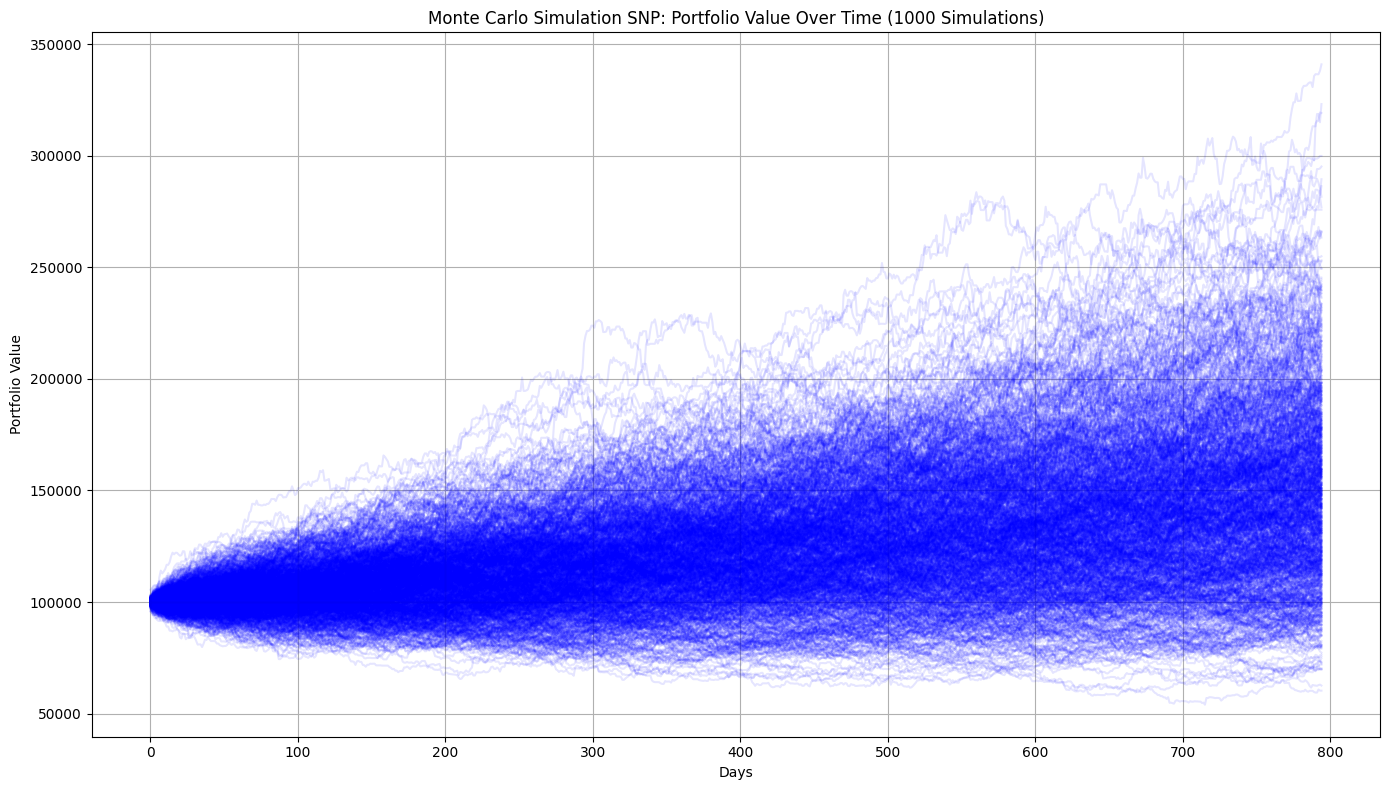

Mean Daily Return: 0.000504
Standard Deviation of Daily Returns: 0.010082
Corrected Sharpe Ratio: 0.67


In [50]:
import numpy as np
import matplotlib.pyplot as plt


def monte_carlo_simulation(
    portfolio_values, num_simulations=1000, num_days=None, initial_capital=100000
):
    """
    Perform Monte Carlo simulation for the portfolio value.

    Parameters:
        portfolio_values (list): List of historical portfolio values for the backtest.
        num_simulations (int): Number of simulations to run.
        num_days (int): Number of days to simulate. If None, use the length of portfolio values.
        initial_capital (float): The starting capital for the simulation.

    Returns:
        np.ndarray: Simulated portfolio values for each run.
    """
    # Use the number of days in portfolio if not provided
    if num_days is None:
        num_days = len(portfolio_values)

    # Calculate daily returns
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]

    # Simulate multiple paths
    simulated_portfolios = np.zeros((num_simulations, num_days))
    for i in range(num_simulations):
        simulated_returns = np.random.choice(daily_returns, size=num_days, replace=True)
        simulated_portfolios[i] = initial_capital * (1 + simulated_returns).cumprod()

    return simulated_portfolios


# Historical portfolio values from backtesting
historical_portfolio_values = results_df["Portfolio_Value"].values

# Run the Monte Carlo simulation
simulated_portfolios = monte_carlo_simulation(
    historical_portfolio_values, num_simulations=1000
)

# Plot the simulated portfolio paths
plt.figure(figsize=(14, 8))
plt.plot(simulated_portfolios.T, color="blue", alpha=0.1)
plt.title("Monte Carlo Simulation SNP: Portfolio Value Over Time (1000 Simulations)")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.grid()
plt.tight_layout()
plt.show()

# Analyze the results

daily_returns_simulated = (
    simulated_portfolios[:, 1:] - simulated_portfolios[:, :-1]
) / simulated_portfolios[:, :-1]
mean_daily_return = np.mean(daily_returns_simulated)
std_daily_return = np.std(daily_returns_simulated)

# Sharpe ratio using daily returns
risk_free_rate = 0.02 / 252  # Assuming 2% annual risk-free rate
excess_daily_return = mean_daily_return - risk_free_rate
sharpe_ratio = (
    excess_daily_return / std_daily_return * np.sqrt(252)
)  # Annualized Sharpe Ratio

# Print corrected key metrics
print(f"Mean Daily Return: {mean_daily_return:.6f}")
print(f"Standard Deviation of Daily Returns: {std_daily_return:.6f}")
print(f"Corrected Sharpe Ratio: {sharpe_ratio:.2f}")


# Sensitivity analysis

In [ ]:
import pandas as pd
import numpy as np


def sensitivity_analysis(data, param_grid, initial_capital=100000):
    """
    Perform sensitivity analysis by varying parameters and tracking performance.

    Parameters:
        data (pd.DataFrame): Historical data for the strategy.
        param_grid (dict): Dictionary of parameter ranges for testing.
        initial_capital (int): Starting portfolio capital.

    Returns:
        pd.DataFrame: Sensitivity analysis results.
    """
    results = []

    # Iterate over all parameter combinations
    for params in ParameterGrid(param_grid):
        # Apply signals with the current parameter set
        data_copy = data.copy()
        data_copy = adjust_signals(
            data_copy,
            rsi_oversold=params["rsi_oversold"],
            rsi_overbought=params["rsi_overbought"],
            bb_band=params["bb_band"],
            adx_threshold=params["adx_threshold"],
            buy_threshold=params["buy_threshold"],
            sell_threshold=params["sell_threshold"],
        )

        # Backtest the strategy
        position = 0
        cash = initial_capital
        portfolio_value = []
        for _, row in data_copy.iterrows():
            current_price = row["Close"]
            if row["Adjusted_Signal"] == 1:  # Buy signal
                if cash > 0:
                    position = cash / current_price
                    cash = 0
            elif row["Adjusted_Signal"] == -1:  # Sell signal
                if position > 0:
                    cash = position * current_price
                    position = 0
            portfolio_value.append(cash + position * current_price)

        # Calculate performance metrics
        cumulative_return = (portfolio_value[-1] - initial_capital) / initial_capital
        daily_returns = np.diff(portfolio_value) / portfolio_value[:-1]
        sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)

        # Store the results
        results.append(
            {
                **params,
                "Cumulative Return": cumulative_return,
                "Sharpe Ratio": sharpe_ratio,
            }
        )

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


# Define the parameter grid
param_grid = {
    "rsi_oversold": [30, 35, 40],
    "rsi_overbought": [60, 65, 70],
    "bb_band": [0.3, 0.5, 0.7],
    "adx_threshold": [20, 25, 30],
    "atr_multiplier": [1.0, 1.5, 2.0],
    "buy_threshold": [2, 3],
    "sell_threshold": [2, 3],
}

# Run sensitivity analysis
sensitivity_results = sensitivity_analysis(snp500_data, param_grid)


In [ ]:
sensitivity_results.iloc[0]

adx_threshold        20.000000
atr_multiplier        1.000000
bb_band               0.300000
buy_threshold         2.000000
rsi_overbought       60.000000
rsi_oversold         30.000000
sell_threshold        2.000000
Cumulative Return     0.187039
Sharpe Ratio          0.764746
Name: 0, dtype: float64

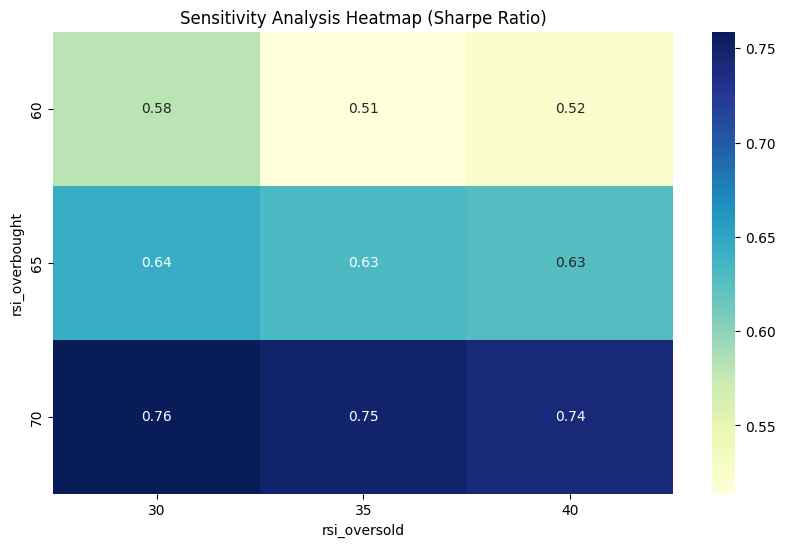

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_heatmap(sensitivity_results, x_param, y_param, metric):
    """
    Plot a heatmap for sensitivity results.

    Parameters:
        sensitivity_results (pd.DataFrame): Results of sensitivity analysis.
        x_param (str): Parameter for the x-axis.
        y_param (str): Parameter for the y-axis.
        metric (str): Metric to visualize (e.g., 'Sharpe Ratio').
    """
    # Pivot data for heatmap
    heatmap_data = sensitivity_results.pivot_table(
        values=metric, index=y_param, columns=x_param, aggfunc="mean"
    )

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f"Sensitivity Analysis Heatmap ({metric})")
    plt.xlabel(x_param)
    plt.ylabel(y_param)
    plt.show()


# Example: Plot heatmap for Sharpe Ratio
plot_heatmap(
    sensitivity_results,
    x_param="rsi_oversold",
    y_param="rsi_overbought",
    metric="Sharpe Ratio",
)

# plot_heatmap(sensitivity_results, x_param='adx_threshold', y_param='rsi_overbought', metric='Cumulative Return')


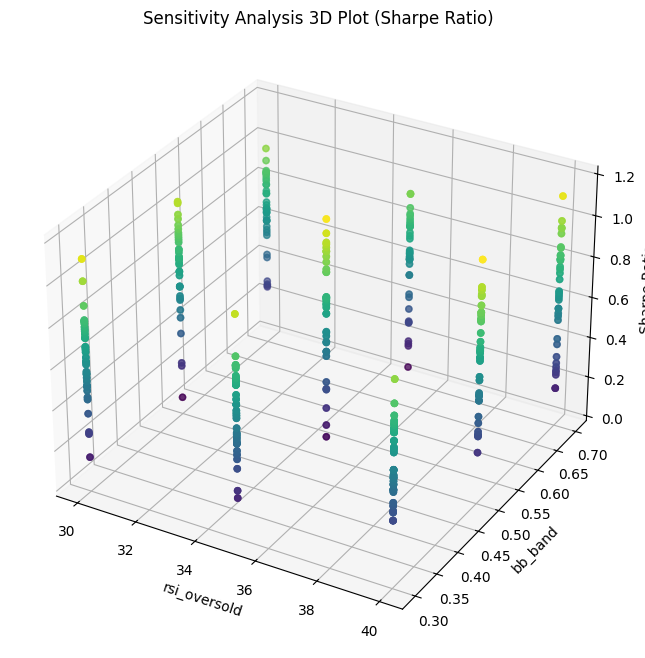

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_surface(sensitivity_results, x_param, y_param, metric):
    """
    Plot a 3D surface plot for sensitivity results.

    Parameters:
        sensitivity_results (pd.DataFrame): Results of sensitivity analysis.
        x_param (str): Parameter for the x-axis.
        y_param (str): Parameter for the y-axis.
        metric (str): Metric for the z-axis (e.g., 'Sharpe Ratio').
    """
    # Extract relevant data
    x = sensitivity_results[x_param]
    y = sensitivity_results[y_param]
    z = sensitivity_results[metric]

    # Plot 3D surface
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x, y, z, c=z, cmap="viridis", marker="o")

    ax.set_title(f"Sensitivity Analysis 3D Plot ({metric})")
    ax.set_xlabel(x_param)
    ax.set_ylabel(y_param)
    ax.set_zlabel(metric)
    plt.show()


# Example: Plot 3D surface for Sharpe Ratio
plot_3d_surface(
    sensitivity_results,
    x_param="rsi_oversold",
    y_param="bb_band",
    metric="Sharpe Ratio",
)


/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_31672/4020555768.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=param, y=metric, data=grouped_data, palette='Blues_d')


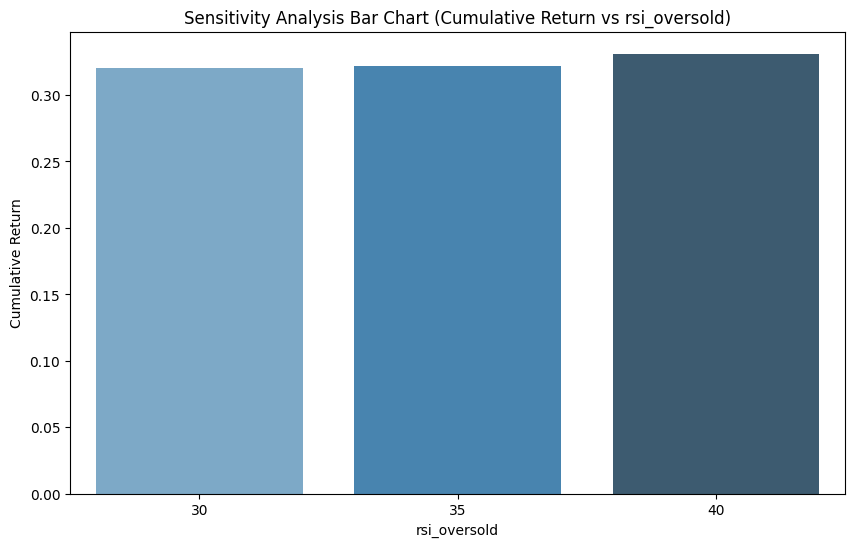

/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_31672/4020555768.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=param, y=metric, data=grouped_data, palette='Blues_d')


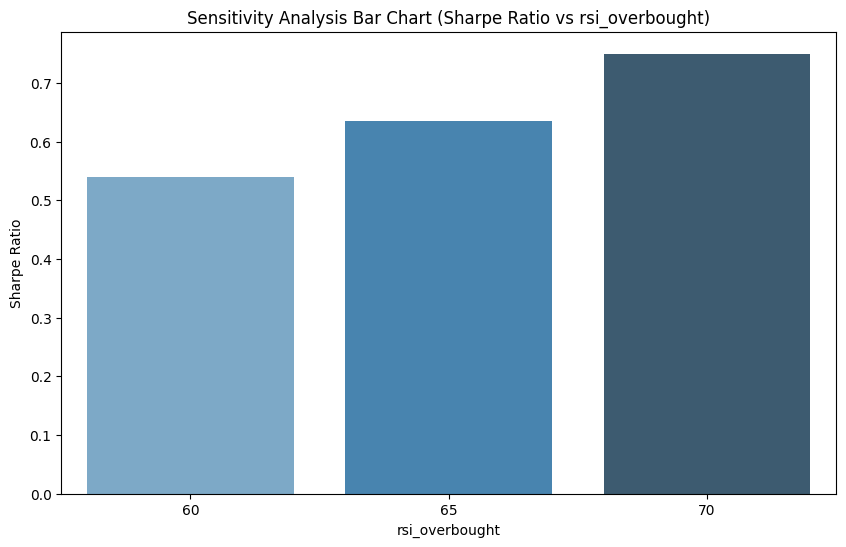

/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_31672/4020555768.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=param, y=metric, data=grouped_data, palette='Blues_d')


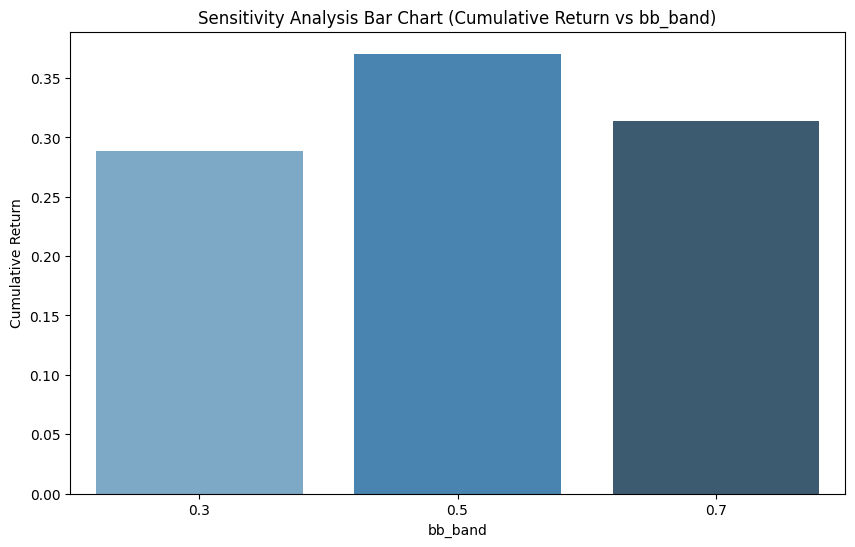

/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_31672/4020555768.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=param, y=metric, data=grouped_data, palette='Blues_d')


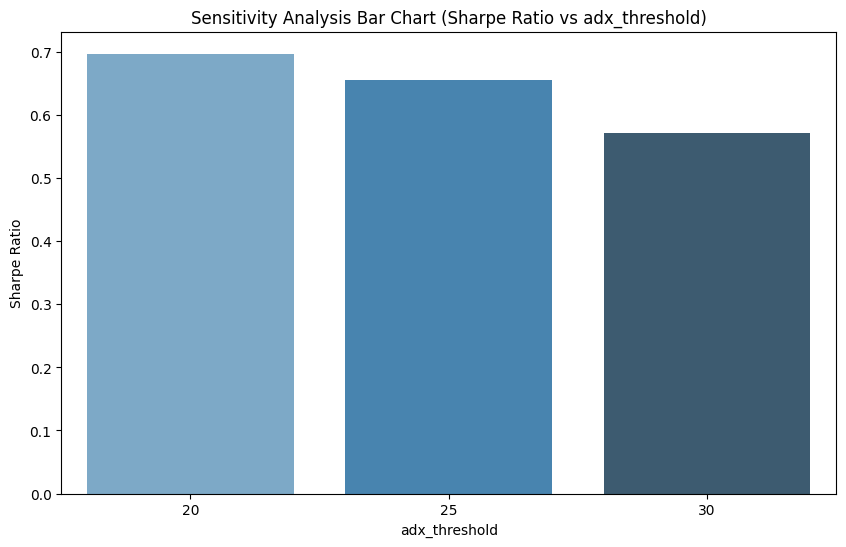

In [ ]:
def plot_bar_chart(sensitivity_results, param, metric):
    """
    Plot a bar chart for a single parameter and metric.

    Parameters:
        sensitivity_results (pd.DataFrame): Results of sensitivity analysis.
        param (str): Parameter to visualize.
        metric (str): Metric to evaluate (e.g., 'Cumulative Return').
    """
    # Group by parameter and calculate the mean metric
    grouped_data = sensitivity_results.groupby(param)[metric].mean().reset_index()

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=param, y=metric, data=grouped_data, palette="Blues_d")
    plt.title(f"Sensitivity Analysis Bar Chart ({metric} vs {param})")
    plt.xlabel(param)
    plt.ylabel(metric)
    plt.show()


# Example: Plot bar chart for RSI Oversold and Cumulative Return
plot_bar_chart(sensitivity_results, param="rsi_oversold", metric="Cumulative Return")
plot_bar_chart(sensitivity_results, param="rsi_overbought", metric="Sharpe Ratio")
plot_bar_chart(sensitivity_results, param="bb_band", metric="Cumulative Return")
plot_bar_chart(sensitivity_results, param="adx_threshold", metric="Sharpe Ratio")


## EDA

In [ ]:
import matplotlib.pyplot as plt
import talib as ta


def plot_indicators(data):
    data["rsi"] = ta.RSI(data["Close"], timeperiod=14)
    data["macd"], data["macd_signal"], _ = ta.MACD(data["Close"])
    data["sma_short"] = ta.SMA(data["Close"], timeperiod=7)
    data["sma_long"] = ta.SMA(data["Close"], timeperiod=14)
    data["atr"] = ta.ATR(data["High"], data["Low"], data["Close"], timeperiod=14)
    data["adx"] = ta.ADX(data["High"], data["Low"], data["Close"], timeperiod=14)
    data["trend_strength"] = abs(data["macd"] - data["macd_signal"])
    data["momentum"] = data["Close"].pct_change(periods=10)  # Momentum calculation

    data["stochastic_k"], _ = talib.STOCH(
        data["High"],
        data["Low"],
        data["Close"],
        fastk_period=14,
        slowk_period=3,
        slowk_matype=0,
        slowd_period=3,
        slowd_matype=0,
    )

    # Adaptive thresholds
    data["trend_strength_threshold"] = (
        data["trend_strength"].rolling(50).mean().fillna(data["trend_strength"].mean())
    )
    data["momentum_threshold"] = (
        data["momentum"].rolling(50).mean().fillna(data["momentum"].mean())
    )

    # Plot price and SMA
    plt.figure(figsize=(12, 6))
    plt.plot(data["Close"], label="Close Price")
    plt.plot(data["sma_short"], label="SMA 50")
    plt.plot(data["sma_long"], label="SMA 200")
    plt.title("Price and SMA")
    plt.legend()
    plt.show()

    # Plot RSI
    plt.figure(figsize=(12, 4))
    plt.plot(data["rsi"], label="RSI")
    plt.axhline(30, color="red", linestyle="--", label="Oversold")
    plt.axhline(70, color="green", linestyle="--", label="Overbought")
    plt.title("RSI")
    plt.legend()
    plt.show()

    # Plot MACD
    plt.figure(figsize=(12, 4))
    plt.plot(data["macd"], label="MACD")
    plt.plot(data["macd_signal"], label="MACD Signal")
    plt.axhline(0, color="black", linestyle="--")
    plt.title("MACD")
    plt.legend()
    plt.show()

    # Plot ATR
    plt.figure(figsize=(12, 4))
    plt.plot(data["atr"], label="ATR")
    plt.title("ATR")
    plt.legend()
    plt.show()

    # Plot ADX
    plt.figure(figsize=(12, 4))
    plt.plot(data["adx"], label="ADX")
    plt.axhline(20, color="red", linestyle="--", label="Weak Trend")
    plt.title("ADX")
    plt.legend()
    plt.show()

    # Plot trend strength with threshold
    plt.figure(figsize=(12, 4))
    plt.plot(data["trend_strength"], label="Trend Strength")
    plt.axhline(
        data["trend_strength_threshold"].mean(),
        color="red",
        linestyle="--",
        label="Threshold",
    )
    plt.title("Trend Strength")
    plt.legend()
    plt.show()

    # Plot momentum with threshold
    plt.figure(figsize=(12, 4))
    plt.plot(data["momentum"], label="Momentum")
    plt.axhline(
        data["momentum_threshold"].mean(),
        color="red",
        linestyle="--",
        label="Threshold",
    )
    plt.title("Momentum")
    plt.legend()
    plt.show()

    # Plot Stochastic
    plt.figure(figsize=(12, 4))
    plt.plot(data["stochastic_k"], label="Stochastic %K")
    plt.axhline(20, color="red", linestyle="--", label="Oversold")
    plt.axhline(80, color="green", linestyle="--", label="Overbought")
    plt.title("Stochastic %K")
    plt.legend()
    plt.show()


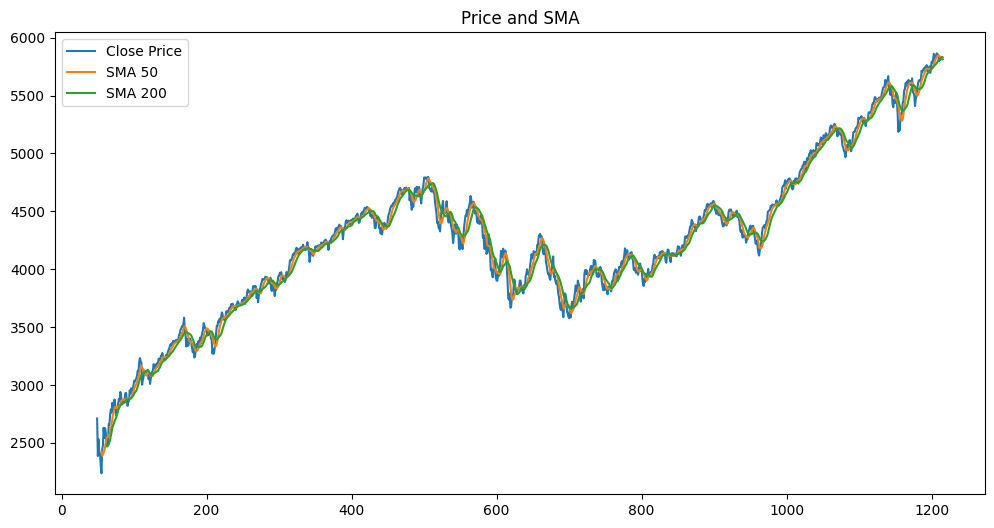

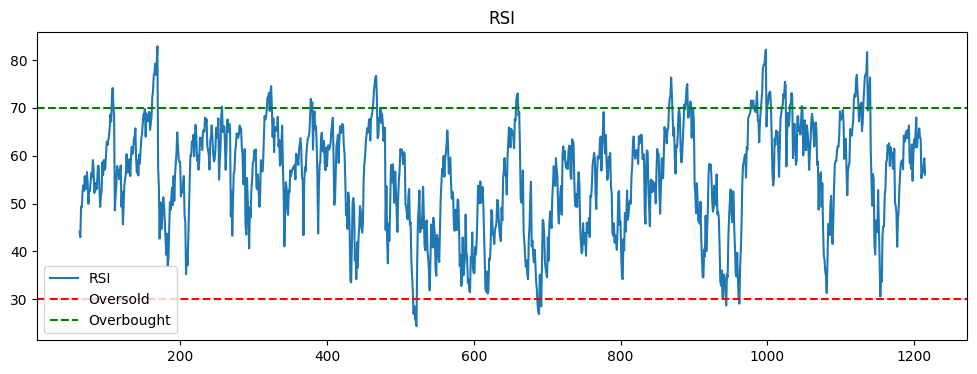

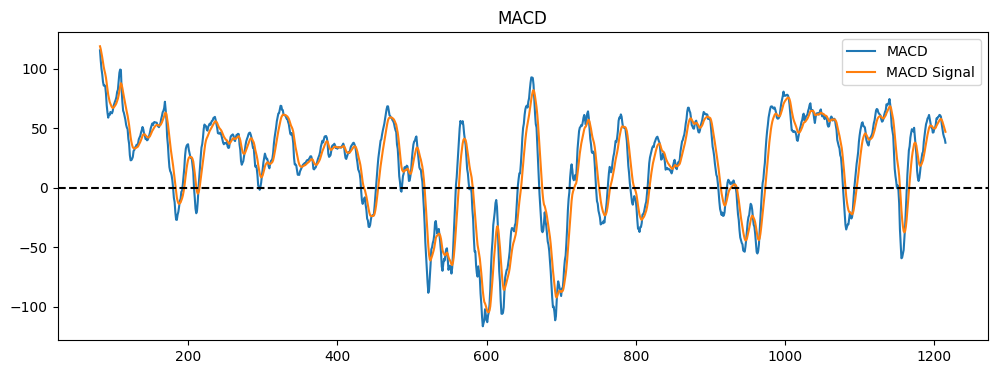

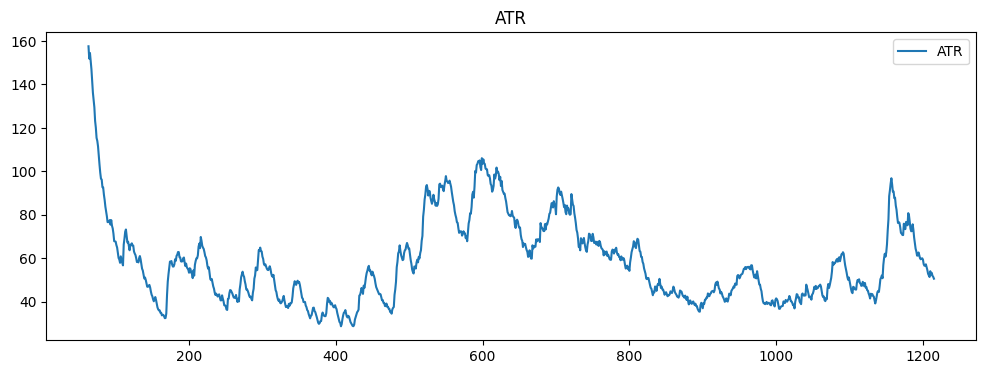

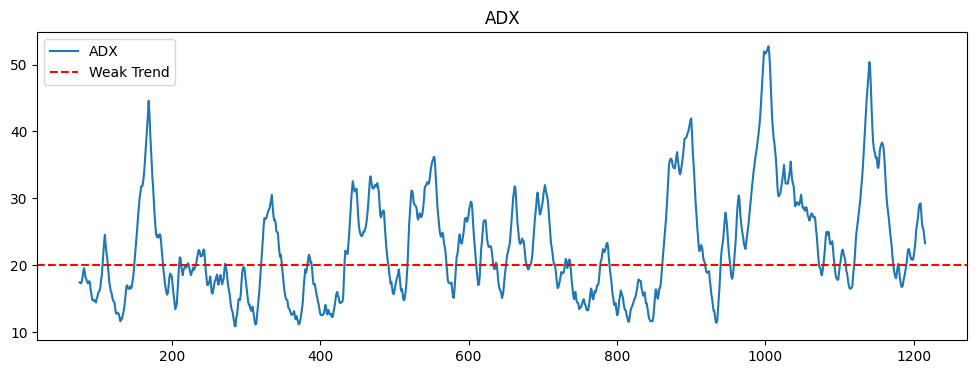

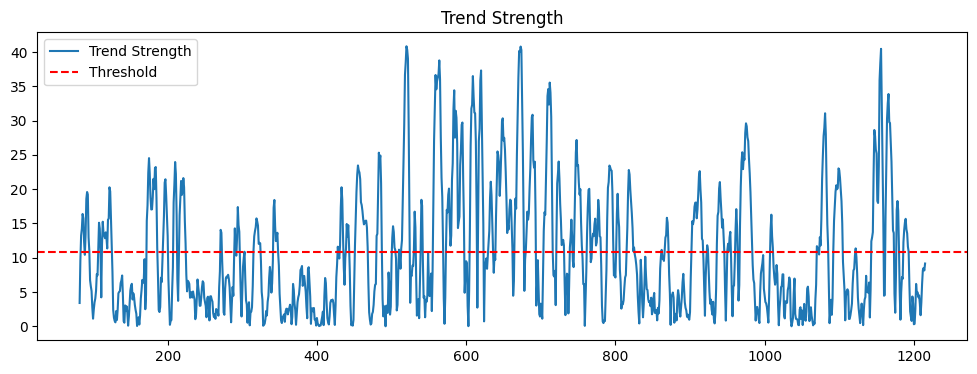

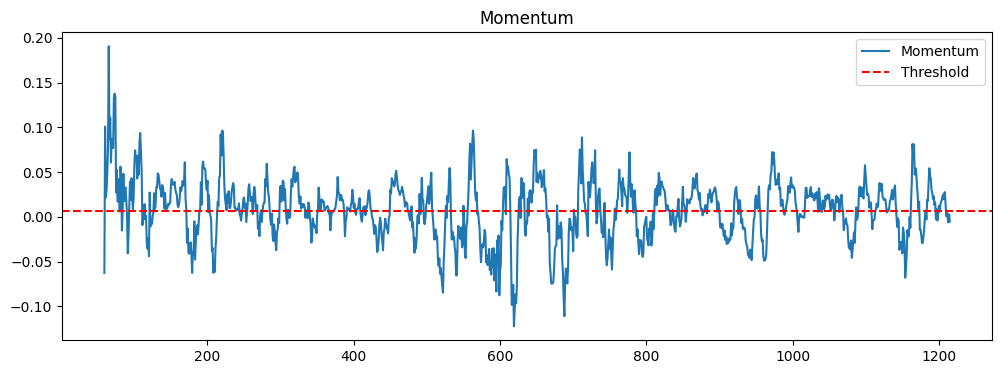

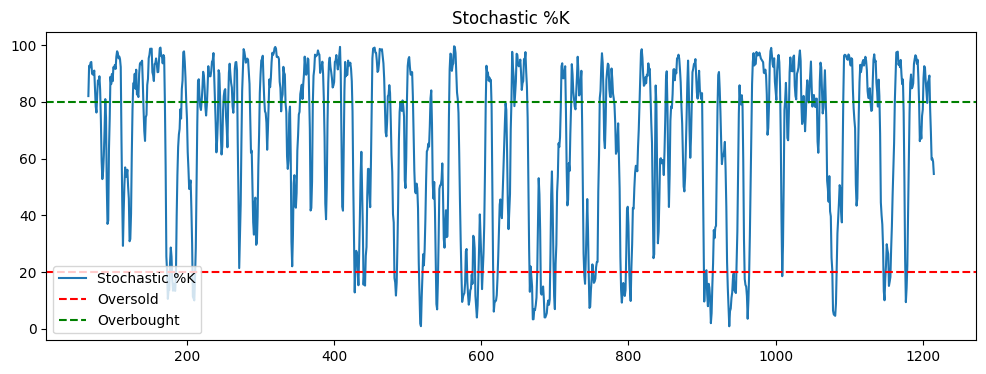

In [ ]:
plot_indicators(snp500_data)